In [82]:
from PIL import Image
import numpy as np
import itertools
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.image import imread
import skimage
from skimage import img_as_uint,img_as_float64, img_as_ubyte
import skimage.io
from skimage.transform import warp, AffineTransform, ProjectiveTransform
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array 
from skimage.exposure import rescale_intensity
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras import Model
from tensorflow.keras import optimizers
import os
import random
from random import seed
from shutil import copyfile, rmtree
from os import makedirs, listdir
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Activation, MaxPooling2D, Dropout, Input,UpSampling2D, Reshape, Conv2DTranspose, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
import cv2
import glob 

In [2]:
FLOWERS_DIR=Path.cwd()/"data"/"flowers"
FLOWERS_PROCESSED_DIR=Path.cwd()/"data"/"flowers_processed"
FLOWERS_PROCESSED_TRAIN_DIR=FLOWERS_PROCESSED_DIR/"train"
FLOWERS_PROCESSED_VALID_DIR=FLOWERS_PROCESSED_DIR/"validation"
FLOWERS_PROCESSED_TEST_DIR=FLOWERS_PROCESSED_DIR/"test"
FLOWER_DAISY_DIR=FLOWERS_DIR/"daisy"
FLOWER_SUNFLOWER_DIR=FLOWERS_DIR/"sunflower"
FLOWER_TULIP_DIR=FLOWERS_DIR/"tulip"
FLOWER_DANDI_DIR=FLOWERS_DIR/"dandelion"
FLOWER_ROSE_DIR=FLOWERS_DIR/"rose"
FLOWERS_TYPE=['daisy', 'sunflower', 'tulip', 'dandelion', 'rose']
FLOWERS_DIRS=[FLOWER_DAISY_DIR, FLOWER_SUNFLOWER_DIR, FLOWER_TULIP_DIR, FLOWER_DANDI_DIR, FLOWER_ROSE_DIR]
FLOWER_ENCODER_DIR=Path.cwd()/"data"/"flowers_encoder"
WIGHTS_DIR=Path.cwd()/"weights"

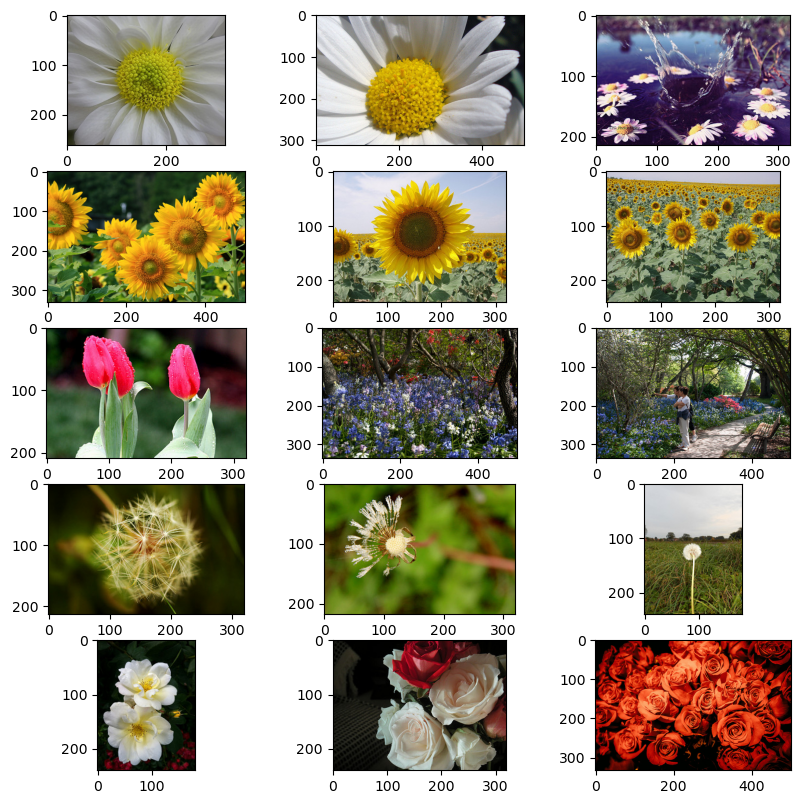

In [3]:
plt.figure(figsize=(10, 10), dpi= 100, facecolor='w', edgecolor='k')
IMAGES_IN_ROW=3
for i, flowers_path in enumerate(FLOWERS_DIRS):
    images=flowers_path.glob("*.jpg")
    for subplot_idx in range(i*IMAGES_IN_ROW+1, (i+1)*IMAGES_IN_ROW+1):    
        plt.subplot(5, 3, subplot_idx)
        image = imread(next(images))
        plt.imshow(image)

In [12]:
def random_affine(image):
    scale_vals=[random.uniform(0.6, 1.4), random.uniform(0.6, 1.4)]
    tform = AffineTransform(scale=(min(scale_vals), max(scale_vals)),
                            rotation=random.uniform(-0.2, 0.2),
                            shear=random.uniform(-0.2, 0.2),
                            translation=(random.uniform(-image.shape[0]//10, image.shape[0]//10), 
                                         random.uniform(-image.shape[1]//10, image.shape[1]//10)))
    return warp(image, tform.inverse, mode='reflect')

def random_crop(image):
    margin = 1/10
    start = [int(random.uniform(0, image.shape[0] * margin)),
             int(random.uniform(0, image.shape[1] * margin))]
    end = [int(random.uniform(image.shape[0] * (1-margin), image.shape[0])), 
           int(random.uniform(image.shape[1] * (1-margin), image.shape[1]))]
    return image[start[0]:end[0], start[1]:end[1]]

In [174]:
for dataset_type in ["train", "test", "validation"]:
    for flower_type in FLOWERS_TYPE:
        path=FLOWERS_PROCESSED_DIR/dataset_type/flower_type
        if os.path.exists(path):
            rmtree(path)
        makedirs(path, exist_ok=True)
seed(1)
val_ratio = 0.15
test_ratio = 0.15
for flower_type in FLOWERS_TYPE:
    src_dir=FLOWERS_DIR/flower_type
    for src_file in src_dir.glob("*.jpg"):
        ran_value=random.random()
        if ran_value<test_ratio:
            dataset_type="test"
        elif test_ratio<=ran_value<test_ratio+val_ratio:
            dataset_type="validation"
        else:
            dataset_type="train"
            image_to_transform = skimage.io.imread(src_file)
            for idx, transformation_f in enumerate([random_affine, random_crop]):
                transformed_image = transformation_f(image_to_transform)
                augmented_path = FLOWERS_PROCESSED_DIR/"train"/flower_type/f"augmented_{idx}_{src_file.name}"
                try:
                    skimage.io.imsave(augmented_path, img_as_ubyte(transformed_image))
                except Exception as exc:
                    try:
                        transformed_image=rescale_intensity(transformed_image,( -1, 1))
                        skimage.io.imsave(augmented_path, img_as_ubyte(transformed_image))
                    except Exception as exc:
                        print(exc)
                        print(str(transformation_f))
        dir_dst=FLOWERS_PROCESSED_DIR/dataset_type/flower_type
        copyfile(src_file, dir_dst/src_file.name)

In [13]:
def create_3_level_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation = "softmax"))
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    model.summary()
    return model

In [4]:
def plot_history(history):
    if 'accuracy' in history.history:
        plt.figure(figsize=(10, 10), dpi= 100, facecolor='w', edgecolor='k')
        plt.subplot(211)
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.subplot(212)
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.plot(history.history['accuracy'], label='train')
        plt.plot(history.history['val_accuracy'], label='test')
        plt.legend()
    else:
        plt.figure(figsize=(10, 10), dpi= 100, facecolor='w', edgecolor='k')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
    plt.show()

In [5]:
def evaluate_model(model, train_datagen, validation_datagen, test_datagen, target_size=(200, 200), epochs=50, batch_size=128, early_stopping=None, shuffle=True):
    train_it = train_datagen.flow_from_directory(f"{FLOWERS_PROCESSED_DIR}/train", class_mode='categorical', batch_size=batch_size, target_size=target_size, shuffle=shuffle)
    validation_it = validation_datagen.flow_from_directory(f"{FLOWERS_PROCESSED_DIR}/validation", class_mode='categorical', batch_size=batch_size, target_size=target_size, shuffle=shuffle)
    test_it = test_datagen.flow_from_directory(f"{FLOWERS_PROCESSED_DIR}/test", class_mode='categorical', batch_size=batch_size, target_size=target_size, shuffle=True)
    callbacks=[]
    if early_stopping:
        callbacks.append(early_stopping)
    else:
        callbacks.append(EarlyStopping(monitor='val_accuracy', mode='max', patience=5))
    history = model.fit(train_it, steps_per_epoch=len(train_it), epochs=epochs, verbose=1, validation_data=validation_it, validation_steps=len(validation_it), callbacks=callbacks)
    loss, accuracy= model.evaluate(test_it, steps=len(test_it), verbose=1)
    print(f"Model loss={loss}, accuracy={accuracy}")
    return history

In [18]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0, zoom_range = 0.1, width_shift_range=0.2, height_shift_range=0.2)
rescale_datagen = ImageDataGenerator(rescale=1.0/255.0)
cnn_model = create_3_level_model()
history=evaluate_model(cnn_model, train_datagen, rescale_datagen, rescale_datagen, epochs=50)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 46, 46, 128)      

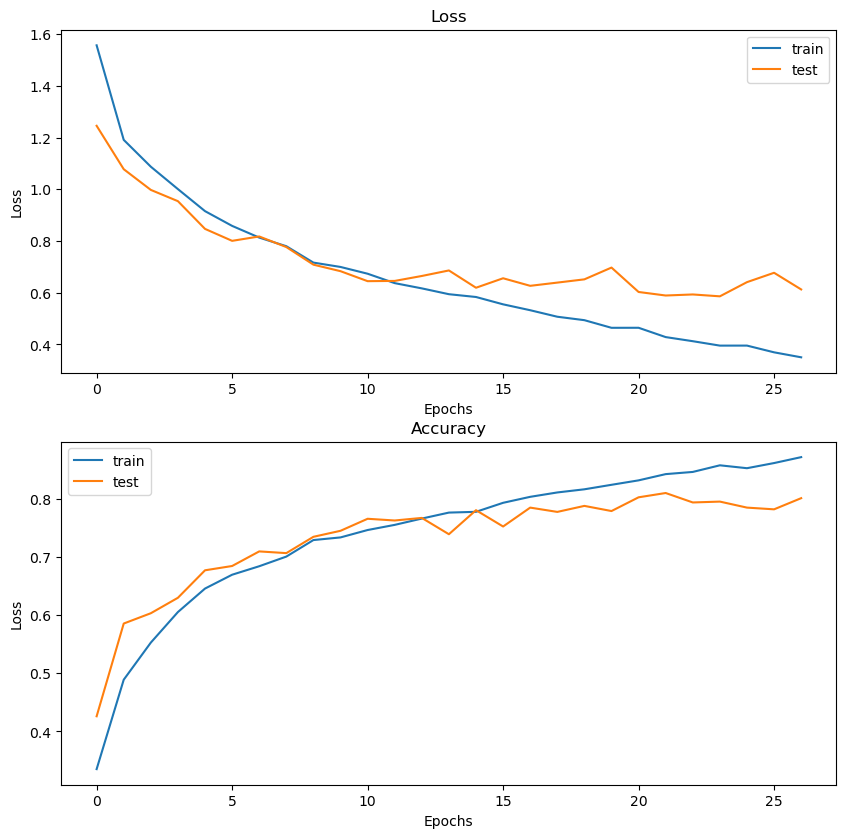

In [19]:
plot_history(history)

In [8]:
ENCODER_IMAGE_SHAPE=(128, 128)
RGB_GRAY_ENCODER_BATCH_SIZE=128

In [7]:
# RGB_GRAY_ENCODER_COLOR_DIR=FLOWER_ENCODER_DIR/"color"
# RGB_GRAY_ENCODER_GRAY_DIR=FLOWER_ENCODER_DIR/"gray"
# for image_type in ["color", "gray"]:
#     path=FLOWER_ENCODER_DIR/image_type
#     if os.path.exists(path):
#         rmtree(path)
#     for flower_type in FLOWERS_TYPE:
#         makedirs(path/flower_type, exist_ok=True)
# for flower_type in FLOWERS_TYPE:
#     src_dir=FLOWERS_DIR/flower_type
#     for src_file in src_dir.glob('*.jpg'):
#         image = cv2.imread(str(src_file))
#         gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image = cv2.resize(image, ENCODER_IMAGE_SHAPE)
#         gray_img = cv2.resize(gray_img, ENCODER_IMAGE_SHAPE)
#         cv2.imwrite(str(RGB_GRAY_ENCODER_GRAY_DIR/flower_type/src_file.name), gray_img)
#         cv2.imwrite(str(RGB_GRAY_ENCODER_COLOR_DIR/flower_type/src_file.name), image)

In [18]:
def encoder_datagen(images_paths, img_size=ENCODER_IMAGE_SHAPE, batch_size=RGB_GRAY_ENCODER_BATCH_SIZE, mode="grayscale"):
    current_image_idx=0
    while True:   
        gray_batch_imgs=[]
        rgb_batch_imgs=[]
        for i in range(batch_size):
            rgb_image=load_img(images_paths[current_image_idx], color_mode="rgb")
            rgb_image_arr=img_to_array(rgb_image.resize(img_size, Image.ANTIALIAS))
            current_image_idx=(current_image_idx+1)%len(images_paths)
            rgb_batch_imgs.append(rgb_image_arr/255.)
            if mode=="grayscale":
                grayscale_image = load_img(images_paths[current_image_idx], color_mode="grayscale")
                grayscale_image_arr = img_to_array(grayscale_image.resize(img_size, Image.ANTIALIAS))
                gray_batch_imgs.append(np.reshape(grayscale_image_arr/255., (grayscale_image_arr.shape[0], grayscale_image_arr.shape[1], 1)))
        if mode=="grayscale":
            yield np.array(rgb_batch_imgs), np.array(gray_batch_imgs)
        elif mode=="same":
            yield np.array(rgb_batch_imgs), np.array(rgb_batch_imgs)

In [17]:
train_images=list(FLOWERS_PROCESSED_TRAIN_DIR.glob("*/*.jpg"))
valid_images=list(FLOWERS_PROCESSED_VALID_DIR.glob("*/*.jpg"))
test_images=list(FLOWERS_PROCESSED_TEST_DIR.glob("*/*.jpg"))
steps_per_epoch_train=len(train_images)/RGB_GRAY_ENCODER_BATCH_SIZE+(0 if len(train_images)%RGB_GRAY_ENCODER_BATCH_SIZE==0 else 1)
steps_per_epoch_valid=len(valid_images)/RGB_GRAY_ENCODER_BATCH_SIZE+(0 if len(valid_images)%RGB_GRAY_ENCODER_BATCH_SIZE==0 else 1)
steps_per_epoch_test=len(test_images)/RGB_GRAY_ENCODER_BATCH_SIZE+(0 if len(valid_images)%RGB_GRAY_ENCODER_BATCH_SIZE==0 else 1)

In [10]:
def create_rgb_autoencoder(input_img):
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.summary()
    return autoencoder

In [16]:
def evaluate_rgb_autoencoder(autoencoder, train_it, validation_it, test_it,  epochs=50, batch_size=64, early_stopping=None):
    callbacks=[]
    callbacks.append(EarlyStopping(monitor='val_loss', mode='min', patience=5))
    history=autoencoder.fit(train_it, steps_per_epoch=steps_per_epoch_train, epochs=epochs, verbose=1, validation_data=validation_it, validation_steps=steps_per_epoch_valid, callbacks=callbacks)
    loss=autoencoder.evaluate(test_it, steps=steps_per_epoch_test, verbose=1)
    print(f"Model loss={loss}")
    return history

In [12]:
input_img=Input(shape=(ENCODER_IMAGE_SHAPE[0], ENCODER_IMAGE_SHAPE[1], 3))
rgb_autoencoder=create_rgb_autoencoder(input_img)
history=evaluate_rgb_autoencoder(rgb_autoencoder, encoder_datagen(train_images),encoder_datagen(valid_images),encoder_datagen(test_images), epochs=25, batch_size=RGB_GRAY_ENCODER_BATCH_SIZE)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)      

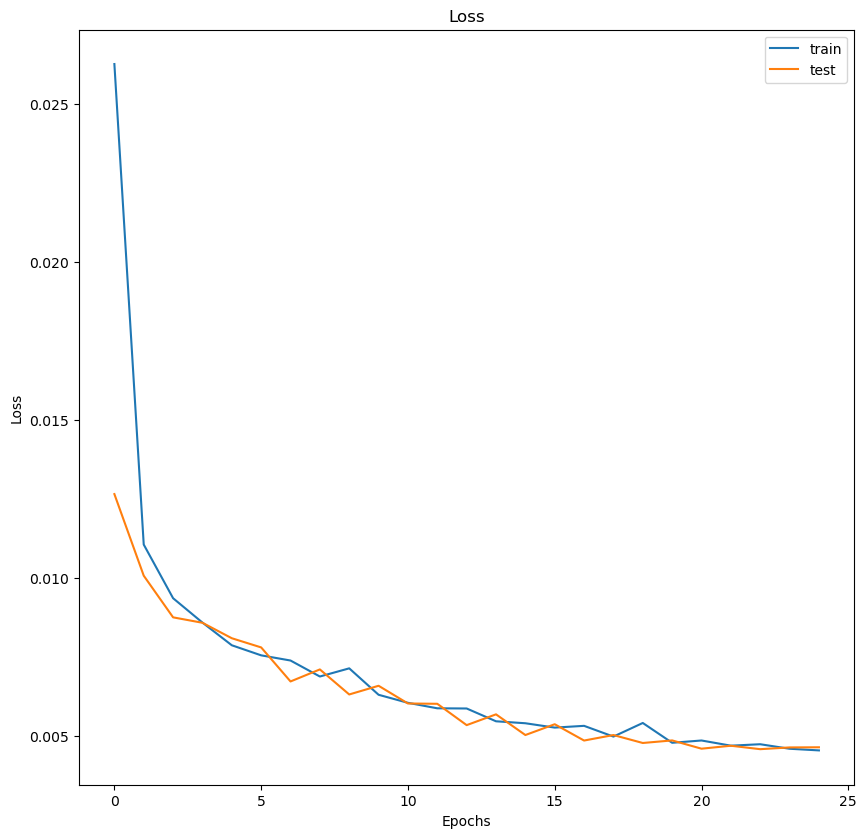

In [15]:
plot_history(history)

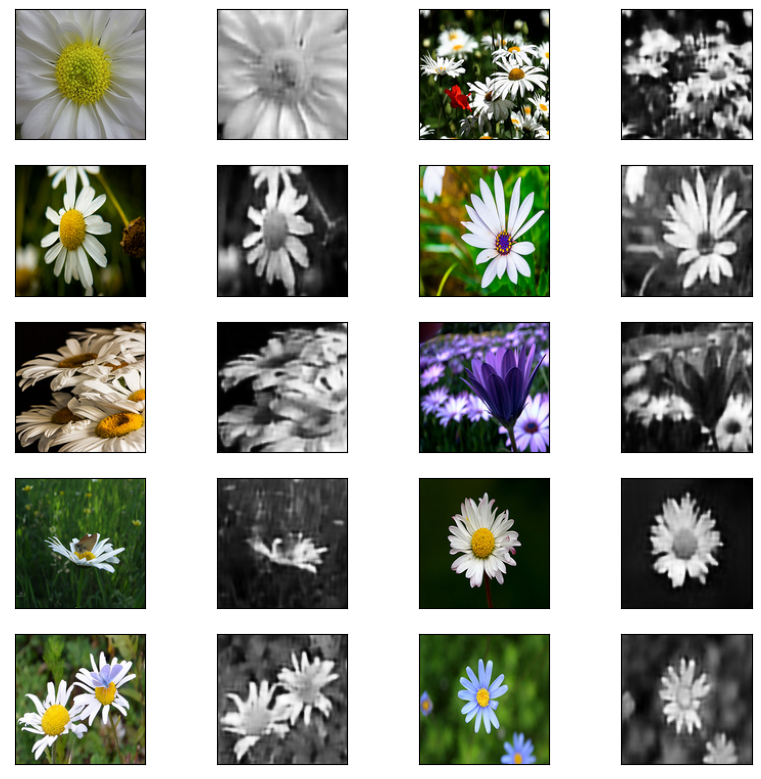

In [22]:
plt.figure(figsize=(10, 10), dpi= 100, facecolor='w', edgecolor='k')
IMAGES_IN_ROW=2
subplot_idx=1
test_images_arr=[]
for i in range(20):
    image = load_img(test_images[i], color_mode="rgb")
    image_arr=img_to_array(image.resize(ENCODER_IMAGE_SHAPE, Image.ANTIALIAS))
    test_images_arr.append(image_arr/255.)
reconstructed_images=rgb_autoencoder.predict(np.array(test_images_arr))
for i, (test_image, reconstructed_image) in enumerate(zip(test_images_arr[:10], reconstructed_images[:10])):
    ax=plt.subplot(5, 4, subplot_idx)
    plt.imshow(test_image)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    subplot_idx+=1
    ax=plt.subplot(5, 4, subplot_idx)
    ax.imshow(reconstructed_image,cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    subplot_idx+=1

In [6]:
def flatten_image_generator(source_iter):
    for X_batch, y_batch in source_iter:
        yield X_batch.reshape(X_batch.shape[0], np.prod(X_batch.shape[1:])), y_batch

In [30]:
input_img = Input(shape = (ENCODER_IMAGE_SHAPE[0], ENCODER_IMAGE_SHAPE[1], 3))
num_classes = 5

In [10]:
def get_encoder(input_img):
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    return x

def get_decoder(encoder_last_l):    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoder_last_l) 
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x) 
    return decoded

In [11]:
def get_autoencoder(input_img):
    autoencoder=Model(input_img, get_decoder(get_encoder(input_img)))
    autoencoder.compile(loss='mean_squared_error', optimizer = 'rmsprop')
    return autoencoder

In [12]:
autoencoder=get_autoencoder(input_img)

In [13]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)       

In [14]:
train_images=list(FLOWERS_PROCESSED_TRAIN_DIR.glob("*/*.jpg"))
valid_images=list(FLOWERS_PROCESSED_VALID_DIR.glob("*/*.jpg"))
test_images=list(FLOWERS_PROCESSED_TEST_DIR.glob("*/*.jpg"))
steps_per_epoch_train=len(train_images)/RGB_GRAY_ENCODER_BATCH_SIZE+(0 if len(train_images)%RGB_GRAY_ENCODER_BATCH_SIZE==0 else 1)
steps_per_epoch_valid=len(valid_images)/RGB_GRAY_ENCODER_BATCH_SIZE+(0 if len(valid_images)%RGB_GRAY_ENCODER_BATCH_SIZE==0 else 1)
steps_per_epoch_test=len(test_images)/RGB_GRAY_ENCODER_BATCH_SIZE+(0 if len(valid_images)%RGB_GRAY_ENCODER_BATCH_SIZE==0 else 1)

In [19]:
history=evaluate_rgb_autoencoder(autoencoder, encoder_datagen(train_images, mode="same"),encoder_datagen(valid_images, mode="same"),encoder_datagen(test_images, mode="same"), epochs=10, batch_size=RGB_GRAY_ENCODER_BATCH_SIZE)

Epoch 1/10
72/71 [==============================] - 837s 12s/step - loss: 0.0385 - val_loss: 0.0782
Epoch 2/10
72/71 [==============================] - 852s 12s/step - loss: 0.0231 - val_loss: 0.0433
Epoch 3/10
72/71 [==============================] - 862s 12s/step - loss: 0.0188 - val_loss: 0.0240
Epoch 4/10
72/71 [==============================] - 878s 12s/step - loss: 0.0160 - val_loss: 0.0299
Epoch 5/10
72/71 [==============================] - 882s 12s/step - loss: 0.0141 - val_loss: 0.0389
Epoch 6/10
72/71 [==============================] - 880s 12s/step - loss: 0.0128 - val_loss: 0.0246
Epoch 7/10
72/71 [==============================] - 870s 12s/step - loss: 0.0117 - val_loss: 0.0255
Epoch 8/10
72/71 [==============================] - 880s 12s/step - loss: 0.0111 - val_loss: 0.0220
Epoch 9/10
72/71 [==============================] - 890s 12s/step - loss: 0.0103 - val_loss: 0.0207
Epoch 10/10
6/5 [==============================] - 10s 2s/step - loss: 0.0196
Model loss=0.019617417

In [36]:
def get_fully_connected_model_with_encoder(input_img, num_classes, num_of_encoder_layers=19):
    encoder = get_encoder(input_img)
    x = Flatten()(encoder)
    x = Dense(128, activation='relu')(x)
    out = Dense(num_classes, activation='softmax')(x)
    full_model = Model(input_img, out)
    return full_model

def set_model_weights(full_model, encoder, num_of_encoder_layers=19):
    for l1,l2 in zip(full_model.layers[:num_of_encoder_layers], encoder.layers[0:num_of_encoder_layers]):
        l1.set_weights(l2.get_weights())
    for layer in full_model.layers[0:num_of_encoder_layers]:
        layer.trainable = False
    return full_model

In [45]:
def evaluate_model_with_ae(model, epochs=20):
    aug_datagen = ImageDataGenerator(rescale=1.0/255.0, zoom_range = 0.1, width_shift_range=0.2, height_shift_range=0.2)
    rescale_datagen = ImageDataGenerator(rescale=1.0/255.0)
    train_it = aug_datagen.flow_from_directory(FLOWERS_PROCESSED_TRAIN_DIR, class_mode='categorical', batch_size=RGB_GRAY_ENCODER_BATCH_SIZE, target_size=ENCODER_IMAGE_SHAPE, shuffle=False, color_mode="rgb")
    validation_it = rescale_datagen.flow_from_directory(f"{FLOWERS_PROCESSED_DIR}/validation", class_mode='categorical', batch_size=RGB_GRAY_ENCODER_BATCH_SIZE, target_size=ENCODER_IMAGE_SHAPE, shuffle=False, color_mode="rgb")
    test_it = rescale_datagen.flow_from_directory(f"{FLOWERS_PROCESSED_DIR}/test", class_mode='categorical', batch_size=RGB_GRAY_ENCODER_BATCH_SIZE, target_size=ENCODER_IMAGE_SHAPE, shuffle=False, color_mode="rgb")
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=5)]
    history = model.fit(train_it, steps_per_epoch=len(train_it), epochs=epochs, verbose=1, validation_data=validation_it, validation_steps=len(validation_it), callbacks=callbacks)
    loss= model.evaluate(test_it, steps=len(test_it), verbose=1)
    print(f"Model loss={loss}")
    return history

In [46]:
fc_with_encoder=get_fully_connected_model_with_encoder(input_img, num_classes)
set_model_weights(fc_with_encoder, autoencoder)
fc_with_encoder.compile(loss='categorical_crossentropy', optimizer='adam')
fc_with_encoder.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_54 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_55 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 64, 64, 64)      

In [47]:
history=evaluate_model_with_ae(fc_with_encoder, epochs=40)

Found 9024 images belonging to 5 classes.
Found 676 images belonging to 5 classes.
Found 639 images belonging to 5 classes.
Epoch 1/40
71/71 [==============================] - 106s 1s/step - loss: 85.9252 - val_loss: 4.5718
Epoch 2/40
71/71 [==============================] - 108s 2s/step - loss: 5.4298 - val_loss: 2.6224
Epoch 3/40
71/71 [==============================] - 108s 2s/step - loss: 3.7437 - val_loss: 2.4165
Epoch 4/40
71/71 [==============================] - 108s 2s/step - loss: 2.5020 - val_loss: 2.0395
Epoch 5/40
71/71 [==============================] - 108s 2s/step - loss: 2.3217 - val_loss: 1.7542
Epoch 6/40
71/71 [==============================] - 109s 2s/step - loss: 2.0462 - val_loss: 2.0465
Epoch 7/40
71/71 [==============================] - 110s 2s/step - loss: 1.9165 - val_loss: 1.9055
Epoch 8/40
71/71 [==============================] - 111s 2s/step - loss: 1.7814 - val_loss: 1.7205
Epoch 9/40
71/71 [==============================] - 110s 2s/step - loss: 1.8476 - v

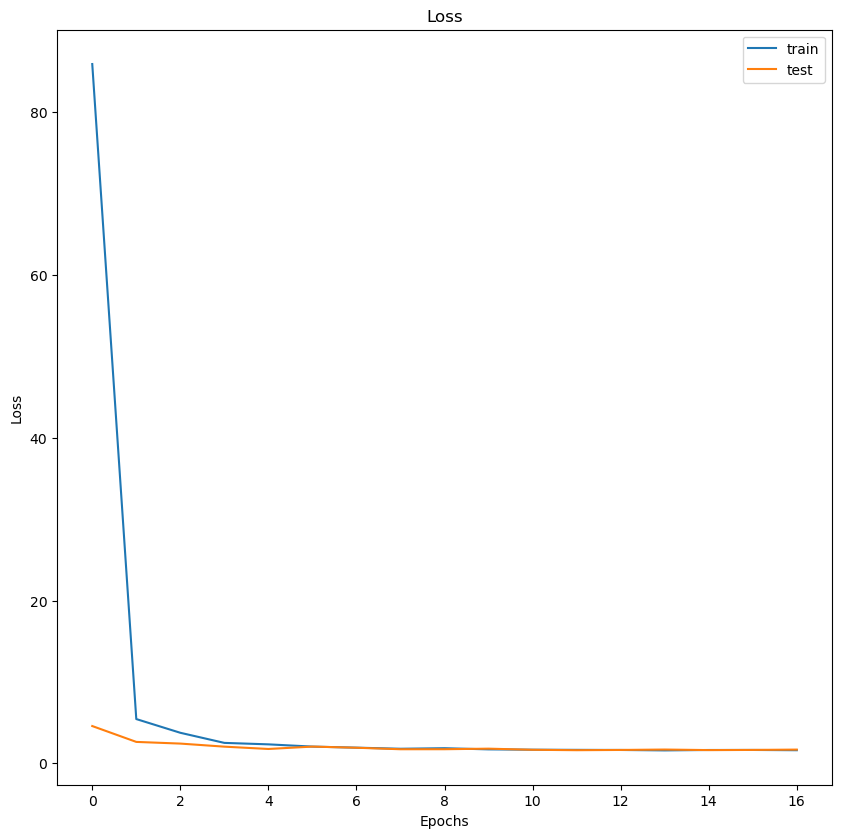

In [48]:
plot_history(history)

In [50]:
def make_layers_trainable(full_model, num_of_encoder_layers=19):
    for layer in full_model.layers[:num_of_encoder_layers]:
        layer.trainable = True

In [52]:
make_layers_trainable(fc_with_encoder)
history=evaluate_model_with_ae(fc_with_encoder, epochs=20)

Found 9024 images belonging to 5 classes.
Found 676 images belonging to 5 classes.
Found 639 images belonging to 5 classes.
Epoch 1/20
71/71 [==============================] - 110s 2s/step - loss: 1.4849 - val_loss: 1.5994
Epoch 2/20
71/71 [==============================] - 116s 2s/step - loss: 1.4932 - val_loss: 1.6436
Epoch 3/20
71/71 [==============================] - 110s 2s/step - loss: 1.5234 - val_loss: 1.6572
Epoch 4/20
71/71 [==============================] - 113s 2s/step - loss: 1.4983 - val_loss: 1.6525
Epoch 5/20
71/71 [==============================] - 114s 2s/step - loss: 1.4504 - val_loss: 1.5295
Epoch 6/20
71/71 [==============================] - 111s 2s/step - loss: 1.4313 - val_loss: 1.7023
Epoch 7/20
71/71 [==============================] - 113s 2s/step - loss: 1.5269 - val_loss: 1.5907
Epoch 8/20
71/71 [==============================] - 111s 2s/step - loss: 1.4911 - val_loss: 1.5939
Epoch 9/20
71/71 [==============================] - 110s 2s/step - loss: 1.4880 - va

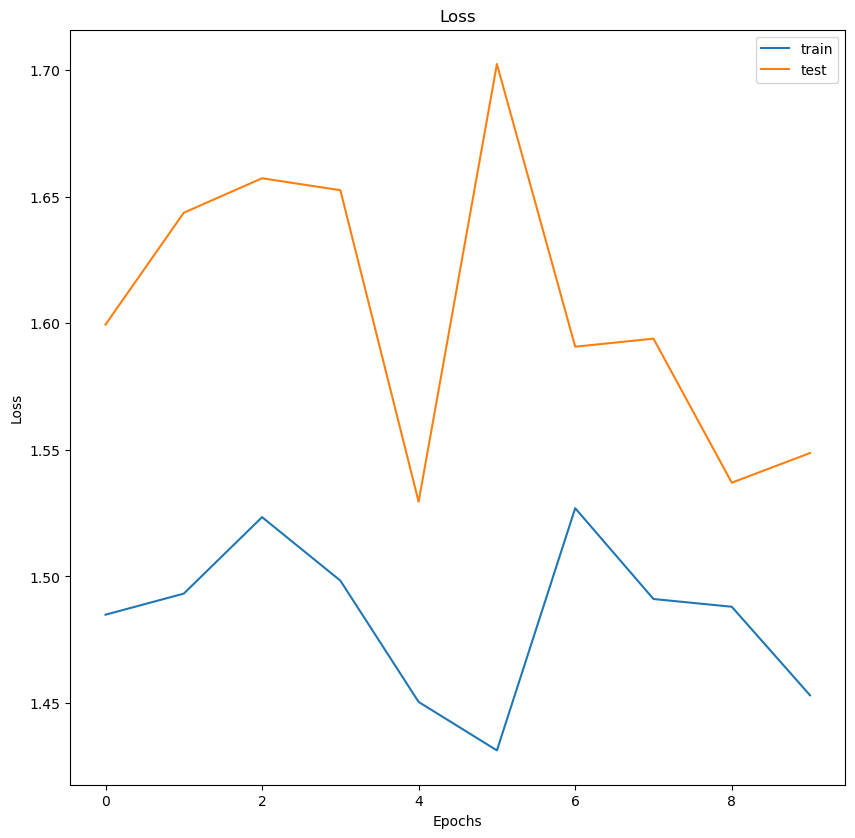

In [53]:
plot_history(history)

In [89]:
rescale_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_it = rescale_datagen.flow_from_directory(f"{FLOWERS_PROCESSED_DIR}/test", class_mode='categorical', batch_size=1024, target_size=ENCODER_IMAGE_SHAPE, shuffle=False, color_mode="rgb")
X_test, y_test=next(test_it)
predicted_classes = fc_with_encoder.predict(X_test)
predicted_classes=np.argmax(predicted_classes, axis=1)

Found 639 images belonging to 5 classes.


In [92]:
y_test_classes=np.argmax(y_test, axis=1)

Found 200 correct labels


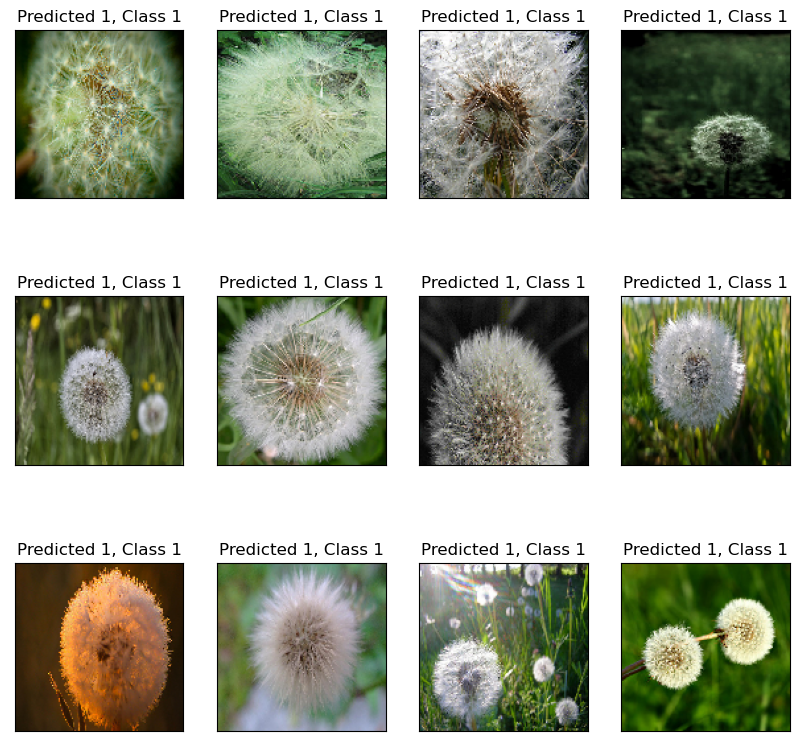

In [99]:
correct = np.where(predicted_classes==y_test_classes)[0]
print(f"Found {len(correct)} correct labels") 
plt.figure(figsize=(10, 10), dpi= 100, facecolor='w', edgecolor='k')
for i, correct in enumerate(correct[:12]):
    ax=plt.subplot(3,4,i+1)
    ax.imshow(X_test[correct])
    ax.set_title(f"Predicted {predicted_classes[correct]}, Class {y_test_classes[correct]}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Found 439 incorrect labels


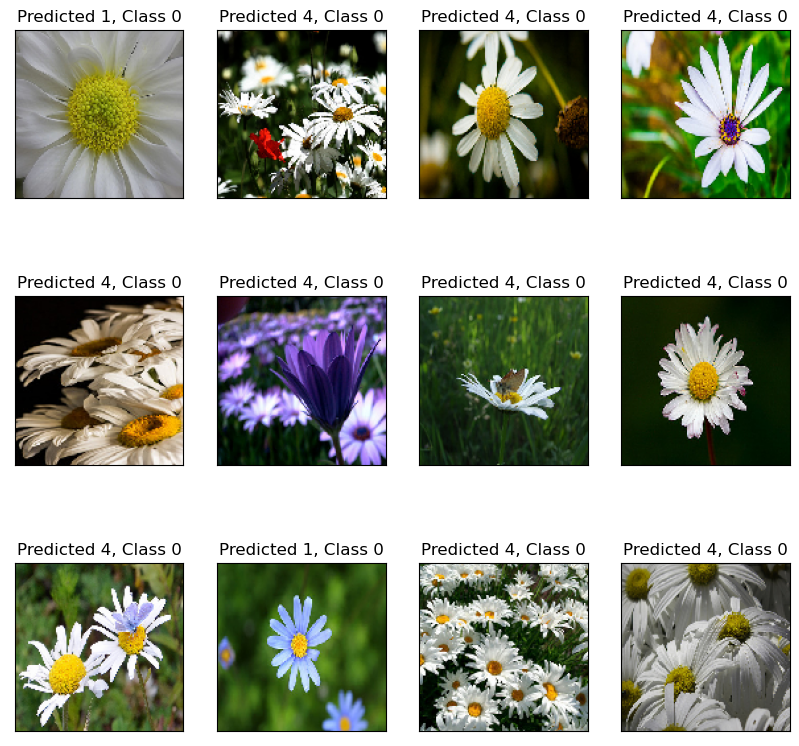

In [102]:
incorrect = np.where(predicted_classes!=y_test_classes)[0]
print(f"Found {len(incorrect)} incorrect labels") 
plt.figure(figsize=(10, 10), dpi= 100, facecolor='w', edgecolor='k')
for i, incorrect in enumerate(incorrect[:12]):
    ax=plt.subplot(3,4,i+1)
    ax.imshow(X_test[incorrect])
    ax.set_title(f"Predicted {predicted_classes[incorrect]}, Class {y_test_classes[incorrect]}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)